# Using 'open virtual dataset' capability to work with TEMPO Level 3 data

--- 


## Summary

In this tutorial, we will use the `earthaccess.open_virtual_mfdataset()` function to open a month's worth of granules from the Nitrogen Dioxide (NO<sub>2</sub>) Level-3 data collection of the [TEMPO air quality mission (link)](https://asdc.larc.nasa.gov/project/TEMPO). We will then calculate means for a subset of the data and visualize the results.

## Prerequisites

- **AWS US-West-2 Environment:** This tutorial has been designed to run in an AWS cloud compute instance in AWS region us-west-2. However, if you want to run it from your laptop or workstation, everything should work just fine but without the speed benefits of in-cloud access.

- **Earthdata Account:** A (free!) Earthdata Login account is required to access data from the NASA Earthdata system. Before requesting TEMPO data, we first need to set up our Earthdata Login authentication, as described in the Earthdata Cookbook's [earthaccess tutorial (link)](https://nasa-openscapes.github.io/earthdata-cloud-cookbook/tutorials/earthaccess-demo.html).

- **Packages:**

  - `cartopy`
  - `dask`
  - `earthaccess` version 0.14.0 or greater
  - `matplotlib`
  - `numpy`
  - `xarray`
## Setup

In [1]:
import cartopy.crs as ccrs
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib import rcParams

%config InlineBackend.figure_format = 'jpeg'
rcParams["figure.dpi"] = (
    80  # Reduce figure resolution to keep the saved size of this notebook low.
)

## Login using the Earthdata Login

In [2]:
auth = earthaccess.login()

if not auth.authenticated:
    # Ask for credentials and persist them in a .netrc file.
    auth.login(strategy="interactive", persist=True)

print(earthaccess.__version__)

0.14.0


## Search for data granules

We search for TEMPO Nitrogen Dioxide ($NO_2$) data for a month-long period (note: times are in UTC) between January and February, 2024.

In [3]:
results = earthaccess.search_data(
    short_name="TEMPO_NO2_L3",
    version="V03",
    temporal=("2024-01-11 12:00", "2024-02-11 12:00"),
)
print(f"Number of results: {len(results)}")

Number of results: 266


## Opening Virtual Multifile Datasets

First we set the argument options to be used by `earthaccess.open_virtual_mfdataset`.

<div class="alert alert-block alert-info">

`load` argument considerations:

- `load=True` works.  Within `earthaccess.open_virtual_mfdataset`, a temporary virtual reference file (a "virtual dataset") is created and then immediately loaded with kerchunk. This is because the function assumes the user is making this request for the first time and the combined manifest file needs to be generated first. In the future, however, `earthaccess.open_virtual_mfdataset` may provide a way to save the combined manifest file, at which point you could then avoid repeating these steps, and proceed directly to loading with kerchunk/virtualizarr.
- `load=False` results in `KeyError: "no index found for coordinate 'longitude'"` because it creates `ManifestArray`s without indexes (see the [earthaccess documentation here (link)](https://github.com/nsidc/earthaccess/blob/7f5fe5d2e42343b6d7948338255cf9bb8cdb2775/earthaccess/dmrpp_zarr.py#L36C456-L36C502))
</div>

In [4]:
open_options = {
    "access": "direct",
    "load": True,
    "concat_dim": "time",
    "coords": "minimal",
    "compat": "override",
    "combine_attrs": "override",
    "parallel": True,
}

Because TEMPO data are processed and archived in a netCDF4 format using a group hierarchy,
we open each group – i.e., 'root', 'product', and 'geolocation' – and then afterwards merge them together.

In [5]:
%%time
result_root = earthaccess.open_virtual_mfdataset(granules=results, **open_options)
result_product = earthaccess.open_virtual_mfdataset(
    granules=results, group="product", **open_options
)
result_geolocation = earthaccess.open_virtual_mfdataset(
    granules=results, group="geolocation", **open_options
)

CPU times: user 10.7 s, sys: 561 ms, total: 11.2 s
Wall time: 28.3 s


Merge root groups with subgroups.

In [6]:
result_merged = xr.merge([result_root, result_product, result_geolocation])
result_merged

<xarray.Dataset> Size: 268GB
Dimensions:                                  (latitude: 2950, longitude: 7750,
                                              time: 266)
Coordinates:
  * latitude                                 (latitude) float32 12kB 14.01 .....
  * longitude                                (longitude) float32 31kB -168.0 ...
  * time                                     (time) datetime64[ns] 2kB 2024-0...
Data variables:
    weight                                   (time, latitude, longitude) float32 24GB dask.array<chunksize=(1, 590, 1550), meta=np.ndarray>
    main_data_quality_flag                   (time, latitude, longitude) float32 24GB dask.array<chunksize=(1, 984, 2584), meta=np.ndarray>
    vertical_column_stratosphere             (time, latitude, longitude) float64 49GB dask.array<chunksize=(1, 738, 1938), meta=np.ndarray>
    vertical_column_troposphere              (time, latitude, longitude) float64 49GB dask.array<chunksize=(1, 738, 1938), meta=np.ndarray>
    vertical_column_troposphere_uncertainty  (time, latitude, longitude) float64 49GB dask.array<chunksize=(1, 738, 1938), meta=np.ndarray>
    relative_azimuth_angle                   (time, latitude, longitude) float32 24GB dask.array<chunksize=(1, 984, 2584), meta=np.ndarray>
    solar_zenith_angle                       (time, latitude, longitude) float32 24GB dask.array<chunksize=(1, 984, 2584), meta=np.ndarray>
    viewing_zenith_angle                     (time, latitude, longitude) float32 24GB dask.array<chunksize=(1, 984, 2584), meta=np.ndarray>
Attributes: (12/40)
    history:                          2024-08-10T19:20:11Z: L2_regrid -v /tem...
    scan_num:                         2
    time_coverage_start:              2024-01-11T12:56:25Z
    time_coverage_end:                2024-01-11T13:36:11Z
    time_coverage_start_since_epoch:  1389013003.147965
    time_coverage_end_since_epoch:    1389015389.7366676
    ...                               ...
    title:                            TEMPO Level 3 nitrogen dioxide product
    collection_shortname:             TEMPO_NO2_L3
    collection_version:               1
    keywords:                         EARTH SCIENCE>ATMOSPHERE>AIR QUALITY>NI...
    summary:                          Nitrogen dioxide Level 3 files provide ...
    coremetadata:                     \nGROUP                  = INVENTORYMET...

## Temporal Mean - a map showing an annual average

In [7]:
temporal_mean_ds = (
    result_merged.sel({"longitude": slice(-78, -74), "latitude": slice(35, 39)})
    .where(result_merged["main_data_quality_flag"] == 0)
    .mean(dim=("time"))
)
temporal_mean_ds

<xarray.Dataset> Size: 2MB
Dimensions:                                  (latitude: 200, longitude: 200)
Coordinates:
  * latitude                                 (latitude) float32 800B 35.01 .....
  * longitude                                (longitude) float32 800B -77.99 ...
Data variables:
    weight                                   (latitude, longitude) float32 160kB dask.array<chunksize=(130, 150), meta=np.ndarray>
    main_data_quality_flag                   (latitude, longitude) float32 160kB dask.array<chunksize=(200, 200), meta=np.ndarray>
    vertical_column_stratosphere             (latitude, longitude) float64 320kB dask.array<chunksize=(200, 200), meta=np.ndarray>
    vertical_column_troposphere              (latitude, longitude) float64 320kB dask.array<chunksize=(200, 200), meta=np.ndarray>
    vertical_column_troposphere_uncertainty  (latitude, longitude) float64 320kB dask.array<chunksize=(200, 200), meta=np.ndarray>
    relative_azimuth_angle                   (latitude, longitude) float32 160kB dask.array<chunksize=(200, 200), meta=np.ndarray>
    solar_zenith_angle                       (latitude, longitude) float32 160kB dask.array<chunksize=(200, 200), meta=np.ndarray>
    viewing_zenith_angle                     (latitude, longitude) float32 160kB dask.array<chunksize=(200, 200), meta=np.ndarray>

In [8]:
%%time
mean_vertical_column_trop = temporal_mean_ds["vertical_column_troposphere"].compute()

CPU times: user 24 s, sys: 7.08 s, total: 31 s
Wall time: 35.4 s


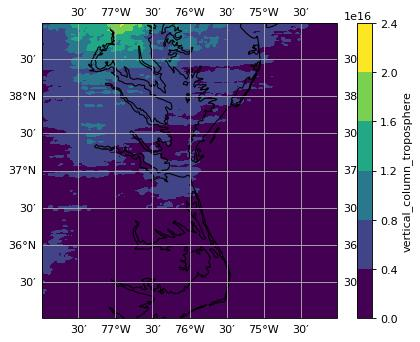

In [9]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

mean_vertical_column_trop.squeeze().plot.contourf(ax=ax)
ax.coastlines()
ax.gridlines(
    draw_labels=True,
    dms=True,
    x_inline=False,
    y_inline=False,
)

## Spatial mean - a time series of area averages

In [10]:
spatial_mean_ds = (
    result_merged.sel({"longitude": slice(-78, -74), "latitude": slice(35, 39)})
    .where(result_merged["main_data_quality_flag"] == 0)
    .mean(dim=("longitude", "latitude"))
)
spatial_mean_ds

<xarray.Dataset> Size: 14kB
Dimensions:                                  (time: 266)
Coordinates:
  * time                                     (time) datetime64[ns] 2kB 2024-0...
Data variables:
    weight                                   (time) float32 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    main_data_quality_flag                   (time) float32 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    vertical_column_stratosphere             (time) float64 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    vertical_column_troposphere              (time) float64 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    vertical_column_troposphere_uncertainty  (time) float64 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    relative_azimuth_angle                   (time) float32 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    solar_zenith_angle                       (time) float32 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    viewing_zenith_angle                     (time) float32 1kB dask.array<chunksize=(1,), meta=np.ndarray>

In [11]:
%%time
spatial_mean_vertical_column_trop = spatial_mean_ds[
    "vertical_column_troposphere"
].compute()

CPU times: user 24.6 s, sys: 7.23 s, total: 31.9 s
Wall time: 28.5 s


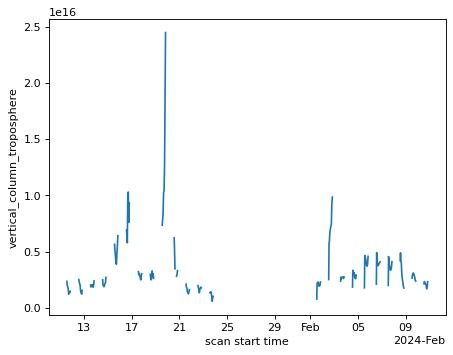

In [12]:
spatial_mean_vertical_column_trop.plot()
plt.show()

## Single scan subset

In [13]:
subset_ds = result_merged.sel(
    {
        "longitude": slice(-78, -74),
        "latitude": slice(35, 39),
        "time": slice(
            np.datetime64("2024-01-11T13:00:00"), np.datetime64("2024-01-11T14:00:00")
        ),
    }
).where(result_merged["main_data_quality_flag"] == 0)
subset_ds

<xarray.Dataset> Size: 2MB
Dimensions:                                  (time: 1, latitude: 200,
                                              longitude: 200)
Coordinates:
  * latitude                                 (latitude) float32 800B 35.01 .....
  * longitude                                (longitude) float32 800B -77.99 ...
  * time                                     (time) datetime64[ns] 8B 2024-01...
Data variables:
    weight                                   (time, latitude, longitude) float32 160kB dask.array<chunksize=(1, 130, 150), meta=np.ndarray>
    main_data_quality_flag                   (time, latitude, longitude) float32 160kB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    vertical_column_stratosphere             (time, latitude, longitude) float64 320kB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    vertical_column_troposphere              (time, latitude, longitude) float64 320kB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    vertical_column_troposphere_uncertainty  (time, latitude, longitude) float64 320kB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    relative_azimuth_angle                   (time, latitude, longitude) float32 160kB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    solar_zenith_angle                       (time, latitude, longitude) float32 160kB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    viewing_zenith_angle                     (time, latitude, longitude) float32 160kB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
Attributes: (12/40)
    history:                          2024-08-10T19:20:11Z: L2_regrid -v /tem...
    scan_num:                         2
    time_coverage_start:              2024-01-11T12:56:25Z
    time_coverage_end:                2024-01-11T13:36:11Z
    time_coverage_start_since_epoch:  1389013003.147965
    time_coverage_end_since_epoch:    1389015389.7366676
    ...                               ...
    title:                            TEMPO Level 3 nitrogen dioxide product
    collection_shortname:             TEMPO_NO2_L3
    collection_version:               1
    keywords:                         EARTH SCIENCE>ATMOSPHERE>AIR QUALITY>NI...
    summary:                          Nitrogen dioxide Level 3 files provide ...
    coremetadata:                     \nGROUP                  = INVENTORYMET...

In [14]:
%%time
subset_vertical_column_trop = subset_ds["vertical_column_troposphere"].compute()

CPU times: user 332 ms, sys: 21.4 ms, total: 353 ms
Wall time: 384 ms


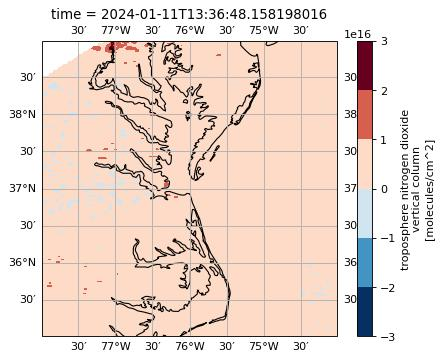

In [15]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

subset_vertical_column_trop.squeeze().plot.contourf(ax=ax)
ax.coastlines()
ax.gridlines(
    draw_labels=True,
    dms=True,
    x_inline=False,
    y_inline=False,
)
plt.show()